In [7]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from discovery.environments.custom_minigrids import TwoRoomEnv
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from stable_baselines3 import PPO
from discovery.utils.feat_extractors import MinigridFeaturesExtractor
from stable_baselines3.common.utils import obs_as_tensor
import itertools
from discovery.environments.custom_minigrids import TwoRoomEnv
from discovery.experiments.FeatAct_minigrid.helpers import pre_process_obs
from sklearn.metrics import confusion_matrix
from discovery.utils import sg_detection 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy
import tqdm
import torch.nn as nn
import torch.optim as optim
import importlib

In [5]:
def make_env_at_pos(position, direction, hallway_pos=(3,7)):
    env = TwoRoomEnv(render_mode="rgb_array",
                     agent_start_pos=position,
                     agent_start_dir=direction,
                     hallway_pos=hallway_pos)
    env = FullyObsWrapper(env)
    env = ImgObsWrapper(env)
    env = Monitor(env)
    return env

def create_dataset(hallway_y=3):
    hallway = (7, hallway_y)
    xs = range(1, 14)
    ys = range(1, 7)
    xys = itertools.product(xs, ys)
    coords_seq = []
    dirs_seq = []
    dirs = range(4)
    all_data = itertools.product(xys, dirs)
    images = []
    obss = []
    labels = []
    for pos_, dir_ in all_data:
        env = make_env_at_pos(position=pos_, direction=dir_, hallway_pos=(hallway[1], hallway[0]))
        try:
            obss.append(env.reset())
            images.append(env.render())
            labels.append(bool(pos_ == hallway))
            coords_seq.append(pos_)
            dirs_seq.append(dir_)
        except AssertionError:
            # print("bad place:", pos_)
            pass
    
    return obss, images, labels, coords_seq, dirs_seq

def obs_to_feats(model, obss):
    feats = []
    with torch.no_grad():
        for obs in obss:
            obs = pre_process_obs(obs[0], model)
            # print(obs[0].shape)
            if model.__class__.__name__ == "DoubleDQN":
                x = model.policy.extract_features(obs, model.policy.q_net.features_extractor)
            elif model.__class__.__name__ == "PPO":
                x = model.policy.extract_features(obs)
            feats.append(x)  
    return feats
    

Number of observations:  292
Shape of obs: (15, 8, 3)


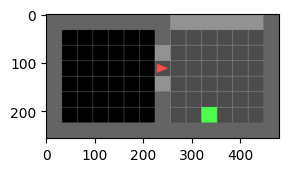

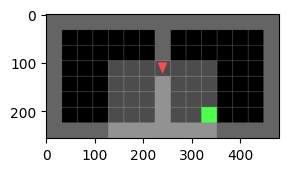

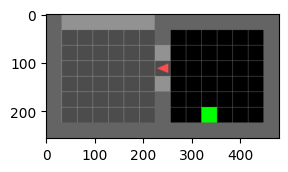

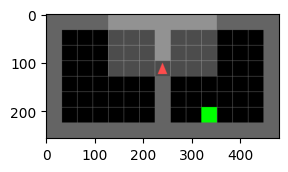

In [6]:
obss, images, labels, coords, dirs = create_dataset(hallway_y=3)
print("Number of observations: ", len(obss))
print("Shape of obs:", obss[0][0].shape)
for idx, image in enumerate(images):
    if labels[idx] == 1:
        plt.figure(figsize=(3, 3))
        plt.imshow(image)

In [ ]:
agent = PPO.load("/Users/kevinroice/Documents/research/discovery/discovery/experiments/FeatAct_minigrid/models/dir_PPO_TwoRoomEnv_wm1nfc2w/model_snapshot_100000_steps.zip")
feats = obs_to_feats(agent, obss)

In [22]:
def train_classifier(clf, feats, labels,
                     n_epochs=500,
                     batch_size=32,
                     test_size=0.2, random_state=0):
    X = torch.cat(feats, dim=0)
    y = torch.tensor(labels).float()
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state)
    
    best_acc = - np.inf
    best_weights = None
    batch_start = torch.arange(0, len(X_train), batch_size) # TODO: check if the last batch is included
    loss_fn = nn.BCELoss(reduction='none')  # reduction='none' to get per-sample loss, not mean

    num_pos = y_train.sum()
    num_neg = len(y_train) - num_pos
    base_weight = torch.tensor([1.0, num_neg/num_pos]) # for weighted mean in loss calculation
    
    optimizer = optim.Adam(clf.parameters(), lr=0.0001)
    # TODO: collect positive examples, and concatenate them to each batch

    for epoch in range(n_epochs):
        clf.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = clf(X_batch)
                y_batch = y_batch.unsqueeze(1)
                weight = torch.where(y_batch == 1, base_weight[1], base_weight[0])
                loss2 = loss_fn(y_pred, y_batch)
                final_loss = torch.mean(weight*loss2)
                # backward pass
                optimizer.zero_grad()
                final_loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(final_loss),
                    acc=float(acc)
                )
        # # evaluate accuracy at end of each epoch
        # clf.eval()
        # y_pred = clf(X_test)
        # acc = (y_pred.round() == y_test).float().mean()
        # acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(clf.state_dict())
    return best_acc

def see_log_reg(clf, feats, labels, coords=coords, dirs=dirs, visiualize=True):
    X = torch.cat(feats, dim=0)
    y = torch.tensor(labels).float()
    y_pred = clf(X)

    torch.set_printoptions(linewidth=150, precision=2)
    base = torch.ones((4,7,14))*torch.nan
    for idx, (coord, dir_) in enumerate(zip(coords,dirs)):
        base[dir_, coord[1], coord[0]] = y_pred[idx].item()
    if visiualize:
        for i in base:
            print(i)

    acc = (y_pred.round() == y).float().mean()
    print("Accuracy: ", acc)
    y_pred_np = y_pred.detach().numpy()
    c_m = confusion_matrix(labels, y_pred_np.round())
    print("Confusion Matrix: ")
    print(c_m)
    return acc, c_m

In [23]:
accuracies = []
timesteps = []
for i in range(100000, 1000001, 100000):
    agent = PPO.load(f"/Users/kevinroice/Documents/research/discovery/discovery/experiments/FeatAct_minigrid/models/dir_PPO_TwoRoomEnv_wm1nfc2w/model_snapshot_{i}_steps.zip")
    feats = obs_to_feats(agent, obss)
    clf = sg_detection.LinearClassifier(input_size=32)
    acc = train_classifier(clf, feats, labels)
    accuracies.append(acc)
    timesteps.append(i)
    print(f"Model at step {i} has accuracy: {acc}")
    acc, c_m = see_log_reg(clf, feats, labels, coords, dirs, visiualize=False)
    print("Confusion Matrix: ")
    print(c_m)
    print("=====================================")

Model at step 100000 has accuracy: 1.0
Accuracy:  tensor(0.99)
Confusion Matrix: 
[[288   0]
 [  4   0]]
Confusion Matrix: 
[[288   0]
 [  4   0]]
Model at step 200000 has accuracy: 1.0
Accuracy:  tensor(0.84)
Confusion Matrix: 
[[245  43]
 [  4   0]]
Confusion Matrix: 
[[245  43]
 [  4   0]]
Model at step 300000 has accuracy: 1.0
Accuracy:  tensor(0.83)
Confusion Matrix: 
[[243  45]
 [  1   3]]
Confusion Matrix: 
[[243  45]
 [  1   3]]
Model at step 400000 has accuracy: 0.4444444477558136
Accuracy:  tensor(0.36)
Confusion Matrix: 
[[105 183]
 [  0   4]]
Confusion Matrix: 
[[105 183]
 [  0   4]]
Model at step 500000 has accuracy: 1.0
Accuracy:  tensor(0.97)
Confusion Matrix: 
[[286   2]
 [  1   3]]
Confusion Matrix: 
[[286   2]
 [  1   3]]
Model at step 600000 has accuracy: 0.8888888955116272
Accuracy:  tensor(0.93)
Confusion Matrix: 
[[274  14]
 [  1   3]]
Confusion Matrix: 
[[274  14]
 [  1   3]]
Model at step 700000 has accuracy: 0.8888888955116272
Accuracy:  tensor(0.87)
Confusion 

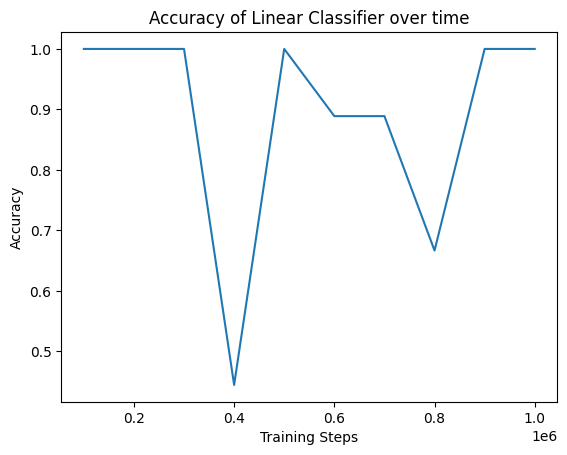

In [24]:
import matplotlib.pyplot as plt
plt.plot(timesteps, accuracies)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy of Linear Classifier over time")
plt.show()

In [25]:
accuracies = []
timesteps = []
for i in range(100000, 1000001, 100000):
    agent = PPO.load(f"/Users/kevinroice/Documents/research/discovery/discovery/experiments/FeatAct_minigrid/models/dir_PPO_TwoRoomEnv_wm1nfc2w/model_snapshot_{i}_steps.zip")
    feats = obs_to_feats(agent, obss)
    clf = sg_detection.NonLinearClassifier(input_size=32, hidden_size=64)
    acc = train_classifier(clf, feats, labels)
    accuracies.append(acc)
    timesteps.append(i)
    print(f"Model at step {i} has accuracy: {acc}")
    acc, c_m = see_log_reg(clf, feats, labels, coords, dirs, visiualize=False)
    print("Confusion Matrix: ")
    print(c_m)
    print("=====================================")

Model at step 100000 has accuracy: 1.0
Accuracy:  tensor(0.99)
Confusion Matrix: 
[[288   0]
 [  4   0]]
Confusion Matrix: 
[[288   0]
 [  4   0]]
Model at step 200000 has accuracy: 0.7777777910232544
Accuracy:  tensor(0.73)
Confusion Matrix: 
[[214  74]
 [  0   4]]
Confusion Matrix: 
[[214  74]
 [  0   4]]
Model at step 300000 has accuracy: 1.0
Accuracy:  tensor(0.76)
Confusion Matrix: 
[[225  63]
 [  0   4]]
Confusion Matrix: 
[[225  63]
 [  0   4]]
Model at step 400000 has accuracy: 0.8888888955116272
Accuracy:  tensor(0.83)
Confusion Matrix: 
[[245  43]
 [  0   4]]
Confusion Matrix: 
[[245  43]
 [  0   4]]
Model at step 500000 has accuracy: 1.0
Accuracy:  tensor(0.94)
Confusion Matrix: 
[[279   9]
 [  0   4]]
Confusion Matrix: 
[[279   9]
 [  0   4]]
Model at step 600000 has accuracy: 1.0
Accuracy:  tensor(0.95)
Confusion Matrix: 
[[280   8]
 [  0   4]]
Confusion Matrix: 
[[280   8]
 [  0   4]]
Model at step 700000 has accuracy: 1.0
Accuracy:  tensor(0.95)
Confusion Matrix: 
[[281 

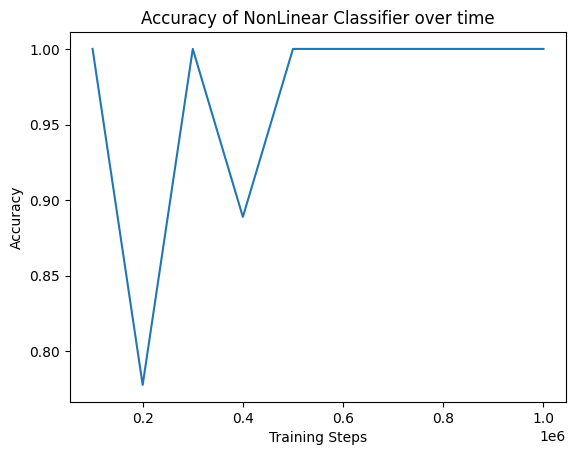

In [26]:
plt.plot(timesteps, accuracies)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy of NonLinear Classifier over time")
plt.show()